# Assignment No.5

## Problem statement: Implement the continuous bag of words(CBOW) model.
Stages can be:
a. Data preparation
b. Generate training data
c. Train model
d. Output

## Objective: 
To predict the word in middle

## Methodology: 
Deep learning, Python 

## Required Libraries: 
numpy, pandas, string, matplotlib, matplotlib.pyplot

## Theory:
The CBOW model tries to understand the context of the words and takes this as input. It then tries to predict 
words that are contextually accurate. Let us consider an example for understanding this. Consider the 
sentence: ‘It is a pleasant day’ and the word ‘pleasant’ goes as input to the neural network. We are trying to 
predict the word ‘day’ here. We will use the one-hot encoding for the input words and measure the error rates 
with the one-hot encoded target word. Doing this will help us predict the output based on the word with least 
error.
Model Architecture:
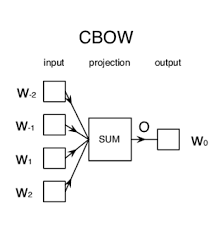
The CBOW model architecture is as shown above. The model tries to predict the target word by trying to 
understand the context of the surrounding words. Consider the same sentence as above, ‘It is a pleasant 
day’.The model converts this sentence into word pairs in the form (contextword, targetword). The user will 
have to set the window size. If the window for the context word is 2 then the word pairs would look like this: 
([it, a], is), ([is, pleasant], a),([a, day], pleasant). With these word pairs, the model tries to predict the target 
word considered the context words. If we have 4 context words used for predicting one target word the input 
layer will be in the form of four 1XW input vectors. These input vectors will be passed to the hidden layer 
where it is multiplied by a WXN matrix. Finally, the 1XN output from the hidden layer enters the sum layer 
where an element-wise summation is performed on the vectors before a final activation is performed and the 
output is obtained.


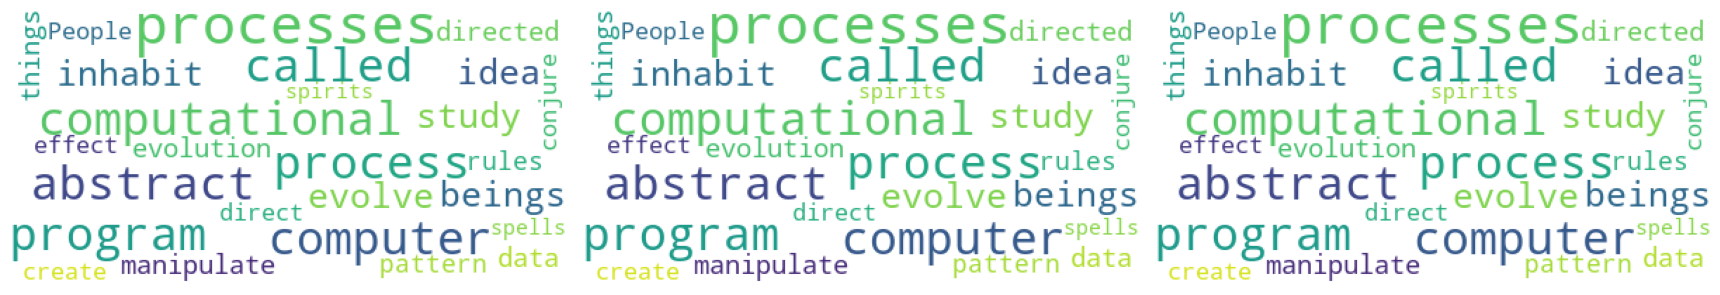

In [3]:
import re
import numpy as np
import string
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
data ="""We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells."""
wordcloud = WordCloud(
background_color='white',
stopwords=stopwords,
max_words=200,
max_font_size=40,
random_state=42
).generate(data)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 24))
axes[0].imshow(wordcloud)
axes[0].axis('off')
axes[1].imshow(wordcloud)
axes[1].axis('off')
axes[2].imshow(wordcloud)
axes[2].axis('off')
fig.tight_layout()


In [5]:
sentences = """We are about to study the idea of a computational process.Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells."""
# remove special characters
sentences = re.sub('[^A-Za-z0-9]+', ' ', sentences)
# remove 1 letter words
sentences = re.sub(r'(?:^| )\w(?:$| )', ' ', sentences).strip()
# lower all characters
sentences = sentences.lower()
words = sentences.split()
vocab = set(words)
vocab_size = len(vocab)
embed_dim = 10
context_size = 2
word_to_ix = {word: i for i, word in enumerate(vocab)}
ix_to_word = {i: word for i, word in enumerate(vocab)}
# data - [(context), target]
data = []
for i in range(2, len(words) - 2):
    context = [words[i - 2], words[i - 1], words[i + 1], words[i + 2]]
    target = words[i]
    data.append((context, target))
print(data[:5])


[(['we', 'are', 'to', 'study'], 'about'), (['are', 'about', 'study', 'the'], 'to'), (['about', 'to', 'the', 'idea'], 'study'), (['to', 'study', 'idea', 'of'], 'the'), (['study', 'the', 'of', 'computational'], 'idea')]


In [6]:
embeddings = np.random.random_sample((vocab_size, embed_dim))

def linear(m, theta):
    w = theta
    return m.dot(w)

def log_softmax(x):
    e_x = np.exp(x - np.max(x))
    return np.log(e_x / e_x.sum())

def NLLLoss(logs, targets):
    out = logs[range(len(targets)), targets]
    return -out.sum()/len(out)

def log_softmax_crossentropy_with_logits(logits,target):
    out = np.zeros_like(logits)
    out[np.arange(len(logits)),target] = 1
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    return (- out + softmax) / logits.shape[0]

def forward(context_idxs, theta):
    m = embeddings[context_idxs].reshape(1, -1)
    n = linear(m, theta)
    o = log_softmax(n)
    return m, n, o

def backward(preds, theta, target_idxs):
    m, n, o = preds
    dlog = log_softmax_crossentropy_with_logits(n, target_idxs)
    dw = m.T.dot(dlog)
    return dw

def optimize(theta, grad, lr=0.03):
    theta -= grad * lr
    return theta

In [7]:
# Training Data
theta = np.random.uniform(-1, 1, (2 * context_size * embed_dim, vocab_size))

epoch_losses = {}
for epoch in range(80):
    losses = []
    for context, target in data:
        context_idxs = np.array([word_to_ix[w] for w in context])
        preds = forward(context_idxs, theta)
        target_idxs = np.array([word_to_ix[target]])
        loss = NLLLoss(preds[-1], target_idxs)
        losses.append(loss)
        grad = backward(preds, theta, target_idxs)
        theta = optimize(theta, grad, lr=0.03)
    epoch_losses[epoch] = losses


Text(0, 0.5, 'Losses')

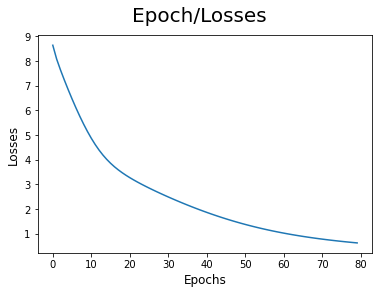

In [8]:
# Analyse
ix = np.arange(0,80)
fig = plt.figure()
fig.suptitle('Epoch/Losses', fontsize=20)
plt.plot(ix,[epoch_losses[i][0] for i in ix])
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Losses', fontsize=12)


In [9]:
def predict(words):
    context_idxs = np.array([word_to_ix[w] for w in words])
    preds = forward(context_idxs, theta)
    word = ix_to_word[np.argmax(preds[-1])]
    return word

In [11]:
# (['we', 'are', 'to', 'study'], 'about')
predict(['we', 'are', 'to', 'study'])


'about'

In [14]:
def accuracy():
    wrong = 0
    for context, target in data:
        if(predict(context) != target):
            wrong += 1
    return (1 - (wrong / len(data)))
accuracy()

1.0